# Аппроксимация смеси гауссианок

В данном ноутбуке ваша цель — аппроксимировать смесь гауссовских распределений. 

In [1]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
noise_dim = 1

mu1, sig1 = [5., 5.], 1.
mu2, sig2 = [15., 15.], 1.
mu3, sig3 = [5., 15.], 1.


In [3]:
def sample_noise(batch_size):
    """ Uniform noise of shape [batch_size, noise_dim] in range [0, 1]"""
    return Variable(torch.rand(batch_size, noise_dim))

def sample_real_data_numpy(batch_size):
    n1, n2 = int(batch_size/3), int(batch_size/3)
    n3 = batch_size - n1 - n2
    
    return np.vstack([np.random.normal(mu1, sig1, (n1, 2)),
                      np.random.normal(mu2, sig2, (n2, 2)),
                      np.random.normal(mu3, sig3, (n3, 2))
                     ])

def sample_real_data(batch_size):
    """ Normal noise of shape [batch_size, 1], mu=5, std=1.5 """
    return Variable(torch.FloatTensor(sample_real_data_numpy(batch_size)))



def plot_2d_density(xy):
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    sns.kdeplot(xy[:, 0], xy[:, 1], cut=5, label='pdata')
#     plt.show()

Данные, с которыми вы будете работать:

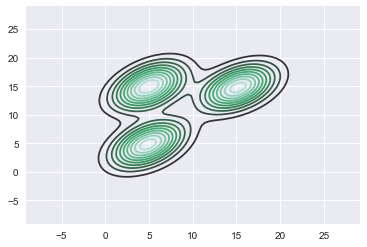

In [4]:
plot_2d_density(sample_real_data_numpy(64))

In [5]:
gen = nn.Sequential(nn.Linear(1, 16), nn.ELU(), nn.Linear(16, 2))
gen_opt = torch.optim.SGD(gen.parameters(), lr=1e-3)

# Discriminator converts 1d data into two logits (0th for real, 1st for fake). 
# It is deliberately made stronger than generator to make sure disc is slightly "ahead in the game".
disc = nn.Sequential(nn.Linear(2, 64), nn.ELU(), nn.Linear(64, 1), nn.Sigmoid())
disc_opt = torch.optim.SGD(disc.parameters(), lr=1e-2)

In [6]:
# we define 0-th output of discriminator as "is_fake" output and 1-st as "is_real"
IS_FAKE, IS_REAL = 0, 1

loss = nn.BCELoss()

def train_disc(batch_size):
    """ trains discriminator for one step """
    
    # compute p(real | x)
    real_data = sample_real_data(batch_size)
    p_real_is_real = disc(real_data)
    
    # compute p(fake | G(z)). We detach to avoid computing gradinents through G(z)
    noise = sample_noise(batch_size)
    gen_data = gen(noise).detach()
    p_gen_is_fake = disc(gen_data) #<compute logp for 0th>
    
#     print(logp_real_is_real, Variable(torch.ones(batch_size, 1)))
    
    disc_loss = loss(p_real_is_real, Variable(torch.ones(batch_size, 1))) +\
                loss(p_gen_is_fake, Variable(torch.zeros(batch_size, 1)))
        
#     print(loss(logp_real_is_real, Variable(torch.ones(batch_size, 1))))
    
    # sgd step. We zero_grad first to clear any gradients left from generator training
    disc_opt.zero_grad()
    disc_loss.backward()
    disc_opt.step()
    return disc_loss.data.numpy()[0]

In [7]:
train_disc(64)

2.8760736

In [8]:
def train_gen(batch_size):
    """ trains generator for one step """
        
    # compute logp(fake | G(z)).
    noise = sample_noise(batch_size)
    gen_data = gen(noise)
    
#     print(gen_data)
    
    p_gen_is_real = disc(gen_data)
    
    gen_loss = loss(p_gen_is_real, Variable(torch.ones(batch_size, 1))).mean()
    
    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()
    return gen_loss.data.numpy()[0]

In [9]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

for i in range(100000):

    for _ in range(5):
        train_disc(128)
    
    train_gen(128)
    
    if i % 250 == 0:
        clear_output(True)
        plt.figure(figsize=[14, 6])
        plt.subplot(1, 2, 1)
        plt.title("Real data")
        plot_2d_density(sample_real_data(1000).data.numpy())
        plt.legend()
        

        plt.subplot(1, 2, 2)
        plt.title("Generated data")
        
        plot_2d_density(gen(sample_noise(100)).data.numpy())      
        
        plt.legend()
        plt.show()

KeyboardInterrupt: 